# Combine phone tokens w/ Oq measurements, visualize

This notebook shows how to slice a token into evenly-spaced measurement points and merge with a set of time-based measurements, followed by several visualizations of the resulting data. Written by Ronald Sprouse and adapted by Amber Galvano.

In [258]:
from io import StringIO
import pandas as pd
import numpy as np
from phonlab.utils import dir2df
import os
import parselmouth as ps
from pathlib import Path
from audiolabel import read_label
import seaborn as sns
np.Inf = np.inf
%matplotlib inline

## Load some test data

Open quotient measurements are in `oqdf`, and labels loaded from a textgrid are in `tgdf`.

In [119]:
oqdf = pd.read_csv('Sansan_OQ_data_12-20-24.csv', index_col=0)
#oqdf = oqdf.loc[:, ['OQ_value', 'OQ_time']]
oqdf = oqdf.sort_values('OQ_time')
oqdf

,OQ_value,OQ_time,recording
0,0.386792,0.450,lob_san_20230323_acg_EGG_SIGNAL_1.wav
1,0.018692,0.455,lob_san_20230323_acg_EGG_SIGNAL_1.wav
2,0.880435,0.460,lob_san_20230323_acg_EGG_SIGNAL_1.wav
3,0.880435,0.465,lob_san_20230323_acg_EGG_SIGNAL_1.wav
4,0.203704,0.475,lob_san_20230323_acg_EGG_SIGNAL_1.wav
...,...,...,...
221914,0.654088,1720.065,SH_20230829_112135_EGG5.wav
221915,0.393617,1720.075,SH_20230829_112135_EGG5.wav
221916,0.668571,1720.200,SH_20230829_112135_EGG5.wav
221917,0.694915,1720.215,SH_20230829_112135_EGG5.wav


In [120]:
# check for measure time values that repeat within the same recording
repeated_rows = oqdf.groupby('recording').apply(lambda group: group[group['OQ_time'].duplicated(keep=False)])
repeated_rows = repeated_rows.reset_index(drop=True)
repeated_rows

/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34982/1793579862.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  repeated_rows = oqdf.groupby('recording').apply(lambda group: group[group['OQ_time'].duplicated(keep=False)])


,OQ_value,OQ_time,recording


In [121]:
oqdf.shape

(283014, 3)

In [122]:
datadir = Path('/Users/ambergalvano/Library/CloudStorage/GoogleDrive-amber_galvano@berkeley.edu/My Drive/research_projects/Lobi/Galvano_Lobi_phonetics/data/EGG+vowels_pt2/full_recordings/Sansan').absolute()
spkrdf = dir2df(datadir, fnpat=r'\.wav$')
spkrdf

,relpath,fname
0,SH_20230323_EGG1,lob_san_20230323_acg_EGG_SIGNAL_1.wav
1,SH_20230823_143156_EGG1,SH_20230823_143156_EGG1.wav
2,SH_20230823_150052_EGG2,SH_20230823_150052_EGG2.wav
3,SH_20230823_152823_EGG3,SH_20230823_152823_EGG3.wav
4,SH_20230829_111622_EGG4,SH_20230829_111622_EGG4.wav
5,SH_20230829_112135_EGG5,SH_20230829_112135_EGG5.wav
6,SH_20230829_115041_EGG6,SH_20230829_115041_EGG6.wav


In [123]:
# Compile TextGrid data
dflist = []

for row in spkrdf.itertuples():
    print(row.relpath)
    
    spkrfile = Path(datadir, row.relpath, row.fname)
    [wrdf, phdf, typedf, posdf, contdf] = read_label(spkrfile.with_suffix('.TextGrid'), ftype='praat', 
                                                     tiers=['word', 'phone', 'wtype', 'position', 'context'])
    phdf = phdf[phdf['phone']!=''].copy()
    wrdf = wrdf[wrdf['word']!=''].copy()

    fname_end_part = str(row.fname).rsplit('/', 1)[-1]
    wrdf['recording'] = fname_end_part
    
    tg = pd.merge_asof(
        phdf[['t1', 't2', 'phone']],               
        wrdf[['t1', 't2', 'word', 'recording']], 
        on='t1', 
        suffixes=['_ph', '_wd']
    )
    
    #tg = pd.merge_asof(phdf, wrdf, on='t1',suffixes=['_ph', '_wd'])
    
    dflist.append(tg)

fulldf = pd.concat(dflist, ignore_index=True)

# tiers = pd.concat(dflist, ignore_index=True)
# tiers = tiers[tiers['word'] != '']
# tiers = tiers[tiers['phone'] != '']
# tiers = tiers.rename(columns={'t1_x':'t1_word', 't1_y':'t1_phone', 'fname_y':'fname'})
# tiers = tiers.iloc[:, [0,1,2,4,5,6]]
fulldf

SH_20230323_EGG1
SH_20230823_143156_EGG1
SH_20230823_150052_EGG2
SH_20230823_152823_EGG3
SH_20230829_111622_EGG4
SH_20230829_112135_EGG5
SH_20230829_115041_EGG6


,t1,t2_ph,phone,t2_wd,word,recording
0,2.963788,3.030533,ɓ,3.030533,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav
1,5.893687,5.969525,ɓ,5.969525,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav
2,9.594150,9.629623,ɓ,9.884122,khuɓ ra,lob_san_20230323_acg_EGG_SIGNAL_1.wav
3,12.326909,12.430703,ɓ,12.719645,khuɓ ra,lob_san_20230323_acg_EGG_SIGNAL_1.wav
4,16.547560,16.604047,ɓ,16.765891,khɔɓa,lob_san_20230323_acg_EGG_SIGNAL_1.wav
...,...,...,...,...,...,...
1050,1574.596111,1574.623583,i,1574.771249,dàwí_le_2,SH_20230829_115041_EGG6.wav
1051,1587.563893,1587.763823,un,1588.617548,sũũn_na_ɪjɛ_1,SH_20230829_115041_EGG6.wav
1052,1590.490725,1590.683186,un,1591.450791,sũũn_na_ɪjɛ_2,SH_20230829_115041_EGG6.wav
1053,1614.998766,1615.049955,ɓ,1615.151454,kʰʊɓa_1,SH_20230829_115041_EGG6.wav


In [124]:
# check for any duplicate t1 values across recordings
# crucial if Oq dataset does not include a column for recording
fulldf['t1'].duplicated().any()

np.False_

In [125]:
# smallest distance between two t1s
# two measurements for a token closer than this will not show meaningful change
fulldf['t1'].sort_values().diff().min()

np.float64(0.0010813637136948273)

In [126]:
fulldf['phone'].unique()

array(['ɓ', "j'", 'b', 'l', 'j', "l'", "w'", 'w', 'kʷʰ', 'gb', 'kp', 'ɪn',
       'b1', 'b2', 'ɡb', 'on', 'e', 'ɪ', 'ɔ', 'ɔn', 'en', 'kp1', 'kp2',
       'ɛn', 'o1', 'o2', 'o', 'ʊ', 'ɛ', 'ɓ1', 'ɓ2', 'in', 'an1', 'an2',
       'u', 'an', 'ɡb1', 'ɡb2', 'a', 'a1', 'a2', 'ʊn', 'i', 'p', 'un',
       "l'1", "l'2", 'ɛm', 'in1', 'in2', 'EP'], dtype=object)

In [127]:
# subset only for phones of interest
consonants = ['ɓ', 'ɓ1', 'ɓ2', 'b', 'l', "l'", "l'1", "l'2", 'j', "j'", 'w', "w'", 'ɡb', 
              'kp', 'kp1', 'kp2', 'gb1', 'ɡb2', 'p']
#vdf = tiers[~tiers['phone'].isin(consonants)]
cdf = fulldf[fulldf['phone'].isin(consonants)]
cdf

,t1,t2_ph,phone,t2_wd,word,recording
0,2.963788,3.030533,ɓ,3.030533,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav
1,5.893687,5.969525,ɓ,5.969525,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav
2,9.594150,9.629623,ɓ,9.884122,khuɓ ra,lob_san_20230323_acg_EGG_SIGNAL_1.wav
3,12.326909,12.430703,ɓ,12.719645,khuɓ ra,lob_san_20230323_acg_EGG_SIGNAL_1.wav
4,16.547560,16.604047,ɓ,16.765891,khɔɓa,lob_san_20230323_acg_EGG_SIGNAL_1.wav
...,...,...,...,...,...,...
1036,1373.804173,1373.869759,l',1374.108511,l'ɪ̃́ɪ̃́n_2,SH_20230829_115041_EGG6.wav
1047,1562.620162,1562.708951,b,1562.908811,dɪbara_1,SH_20230829_115041_EGG6.wav
1048,1564.939936,1565.031588,b,1565.214893,dɪbara_2,SH_20230829_115041_EGG6.wav
1053,1614.998766,1615.049955,ɓ,1615.151454,kʰʊɓa_1,SH_20230829_115041_EGG6.wav


## `np.linspace`

The [`np.linspace` function](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) is a convenient way to slice up a time duration into any number of segments. For example, to create three evenly-spaced timepoints for the first `ɓ` token:

In [128]:
tpts = np.linspace(start=106.156219, stop=106.267926, num=10)
tpts

array([106.156219  , 106.16863089, 106.18104278, 106.19345467,
       106.20586656, 106.21827844, 106.23069033, 106.24310222,
       106.25551411, 106.267926  ])

You can use these values to create a column in a dataframe that includes other metadata related to this token:

In [129]:
longdf = pd.DataFrame({
    'tpt': tpts,
    'tpt_idx': [f'tpt{n}' for n in np.arange(len(tpts))], # Mainly useful if you pivot to wide format.
    't1': 106.156219,
    't2': 106.267926,
    'phone': 'ɓ',
    'recording': 'SH_20230829_115041_EGG6.wav'
})
longdf

,tpt,tpt_idx,t1,t2,phone,recording
0,106.156219,tpt0,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav
1,106.168631,tpt1,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav
2,106.181043,tpt2,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav
3,106.193455,tpt3,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav
4,106.205867,tpt4,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav
5,106.218278,tpt5,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav
6,106.230690,tpt6,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav
7,106.243102,tpt7,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav
8,106.255514,tpt8,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav
9,106.267926,tpt9,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav


Now do a [`merge_asof`](https://pandas.pydata.org/docs/reference/api/pandas.merge_asof.html) with your `OQ` measurements.

Read the [`merge_asof` documentation](https://pandas.pydata.org/docs/reference/api/pandas.merge_asof.html) to understand the parameters. You might want to use the `tolerance` parameter to ensure that `OQ_time` is reasonably close to `tpt`, for example. If you set the `tolerance` to 0.01 then the `OQ_value` and `OQ_time` values would be `NaN` in the last row. As you can see, the times in the last row are more than 10ms apart:

In [130]:
longdf = pd.merge_asof(longdf, oqdf, by='recording', left_on='tpt', right_on='OQ_time', direction='nearest')
longdf
# with new data, merge 'by' recording and 'left_on' tpt and 'right_on' OQ_time
# check for duplicates in OQ_times; if so, there are duplicate measurements for very close-together timepoints
# also can groupby token and check for matches between OQ_times and tpt (are there enough OQ values to get 10 tpts?)

,tpt,tpt_idx,t1,t2,phone,recording,OQ_value,OQ_time
0,106.156219,tpt0,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.333333,106.155
1,106.168631,tpt1,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.351064,106.165
2,106.181043,tpt2,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.336957,106.180
3,106.193455,tpt3,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.648438,106.195
4,106.205867,tpt4,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.593985,106.205
5,106.218278,tpt5,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.557971,106.220
6,106.230690,tpt6,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.561151,106.230
7,106.243102,tpt7,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.567376,106.245
8,106.255514,tpt8,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.570423,106.255
9,106.267926,tpt9,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.576389,106.270


In [131]:
# longer than min dist between Oq times, but can't fit 10 of min Oq time inside (only 3)
# this shouldn't be a problem if we can still plot some change across the token
print(abs(longdf['t2']-longdf['t1']).min())
print(abs(longdf['tpt'] - longdf['OQ_time']).max())

0.11170700000000977
0.003630888888878303


In [132]:
# no duplicates
longdf['OQ_time'].duplicated().any()

np.False_

In [134]:
def check_ten_OQ_times(group):
    unique_OQ_times = group['OQ_time'].nunique()  # Count unique OQ_time values
    return unique_OQ_times >= 10  # Return True if there are at least 10 unique OQ_time values

# Group by t1 and t2 and apply the function
grouped = longdf.groupby(['t1', 't2']).apply(check_ten_OQ_times).reset_index(name='enough_OQ_times')

# this token has 10 Oq values per token
print(grouped['enough_OQ_times'].sum())
print(grouped.shape[0])

1
1


/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34982/1599295436.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = longdf.groupby(['t1', 't2']).apply(check_ten_OQ_times).reset_index(name='enough_OQ_times')


In [136]:
unique_OQ_count = longdf.groupby(['t1', 't2'])['OQ_time'].nunique().reset_index(name='unique_OQ_count')
unique_OQ_count

,t1,t2,unique_OQ_count
0,106.156219,106.267926,10


In [137]:
longdf1 = pd.merge(longdf, unique_OQ_count, on=['t1', 't2'], how='left')
longdf1

,tpt,tpt_idx,t1,t2,phone,recording,OQ_value,OQ_time,unique_OQ_count
0,106.156219,tpt0,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.333333,106.155,10
1,106.168631,tpt1,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.351064,106.165,10
2,106.181043,tpt2,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.336957,106.180,10
3,106.193455,tpt3,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.648438,106.195,10
4,106.205867,tpt4,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.593985,106.205,10
5,106.218278,tpt5,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.557971,106.220,10
6,106.230690,tpt6,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.561151,106.230,10
7,106.243102,tpt7,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.567376,106.245,10
8,106.255514,tpt8,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.570423,106.255,10
9,106.267926,tpt9,106.156219,106.267926,ɓ,SH_20230829_115041_EGG6.wav,0.576389,106.270,10


In [138]:
(np.abs(longdf['tpt'] - longdf['OQ_time']) > 0.01).any()

np.False_

**Aside:** The dataframe is in [long format](https://towardsdatascience.com/reshaping-a-pandas-dataframe-long-to-wide-and-vice-versa-517c7f0995ad). You might like that shape, or perhaps you prefer a wide format:

In [139]:
longdf.pivot(index=['t1', 't2', 'phone'], columns=['tpt_idx'], values=['tpt', 'OQ_value', 'OQ_time'])

tpt                                      \
tpt_idx                            tpt0        tpt1        tpt2        tpt3   
t1         t2         phone                                                   
106.156219 106.267926 ɓ      106.156219  106.168631  106.181043  106.193455   

                                                                            \
tpt_idx                            tpt4        tpt5       tpt6        tpt7   
t1         t2         phone                                                  
106.156219 106.267926 ɓ      106.205867  106.218278  106.23069  106.243102   

                                                     ...  OQ_time           \
tpt_idx                            tpt8        tpt9  ...     tpt0     tpt1   
t1         t2         phone                          ...                     
106.156219 106.267926 ɓ      106.255514  106.267926  ...  106.155  106.165   

                                                                       \
tpt_idx                        tpt2     tpt3     tpt4    tpt5    tpt6   
t1         t2         phone                                             
106.156219 106.267926 ɓ      106.18  106.195  106.205  106.22  106.23   

                                                       
tpt_idx                         tpt7     tpt8    tpt9  
t1         t2         phone                            
106.156219 106.267926 ɓ      106.245  106.255  106.27  

[1 rows x 30 columns]

## Loop: Using a function and  `itertuples` to collect all token measurements

The preceding cells illustrate how to create a dataframe of measurements for one token. The next step is to package the dataframe creation into a function. This function returns a dataframe in either `long` or `wide` format.

In [140]:
# be sure to update this loop with changes made 12/19
# can add warnings to check each step

def row2df(row, mdf, num, fmt):
    '''
    Create and return a dataframe of token measurements.
    
    row: token named tuple returned by `itertuples`
    
    mdf: measurement dataframe with times that correspond to `row` times
    
    num: number of measurements per token
    
    fmt: 'long' or 'wide' 
    
    Returns: token-measurement dataframe in long format
    '''
    tpts = np.linspace(row.t1, row.t2_ph, num=num)
    # Create token-times dataframe
    longdf = pd.DataFrame({
        'tpt': tpts,
        'tpt_idx': [f'tpt{n}' for n in np.arange(len(tpts))],
        't1': row.t1,
        't2': row.t2_ph,
        'phone': row.phone,
        'word': row.word,
        'recording': row.recording
    })
    # Merge measurements -- add 'by' parameter here
    longdf = pd.merge_asof(longdf, oqdf, by='recording', left_on='tpt', right_on='OQ_time', direction='nearest')
    
    if fmt == 'long':
        return longdf
    elif fmt == 'wide':
        return longdf.pivot(
            index=['t1', 't2', 'phone', 'word', 'recording'],
            columns=['tpt_idx'],
            values=['tpt', 'OQ_value', 'OQ_time']
        )
    else:
        raise RuntimeError("`fmt` parameter must be 'long' or 'wide'")

Then iterate over the non-empty phones and create a dataframe of token-time-measurements for each token. These are collected in a Python list and then concatenated into a single dataframe.

In [141]:
tptdf = pd.concat(
    [
        row2df(x, oqdf, 10, 'long') for x in cdf[cdf['phone'] != ''].itertuples()
    ],
    axis='rows'
).reset_index()
tptdf

,index,tpt,tpt_idx,t1,t2,phone,word,recording,OQ_value,OQ_time
0,0,2.963788,tpt0,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.528571,2.965
1,1,2.971204,tpt1,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.586667,2.970
2,2,2.978620,tpt2,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.616352,2.980
3,3,2.986036,tpt3,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.618497,2.990
4,4,2.993452,tpt4,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.618497,2.990
...,...,...,...,...,...,...,...,...,...,...
6465,5,1617.184040,tpt5,1617.163650,1617.200353,ɓ,kʰʊɓa_2,SH_20230829_115041_EGG6.wav,0.647887,1617.185
6466,6,1617.188119,tpt6,1617.163650,1617.200353,ɓ,kʰʊɓa_2,SH_20230829_115041_EGG6.wav,0.647887,1617.190
6467,7,1617.192197,tpt7,1617.163650,1617.200353,ɓ,kʰʊɓa_2,SH_20230829_115041_EGG6.wav,0.647887,1617.190
6468,8,1617.196275,tpt8,1617.163650,1617.200353,ɓ,kʰʊɓa_2,SH_20230829_115041_EGG6.wav,0.644928,1617.195


In [ ]:
#tptdf.to_csv('./Sansan_OQ_FULL_12-20-24.csv', index=False)

### Check matches of Oq measurements and tokens

In [165]:
# how many tokens have at least 10 Oq measurements available
grouped1 = tptdf.groupby(['t1', 't2']).apply(check_ten_OQ_times).reset_index(name='enough_OQ_times')

# 136/645 have 10 Oq values per token, so some values will repeat at time points
print(grouped1['enough_OQ_times'].sum())
print(grouped1.shape[0])

136
647


/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34982/1296994232.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped1 = tptdf.groupby(['t1', 't2']).apply(check_ten_OQ_times).reset_index(name='enough_OQ_times')


In [159]:
# get unique tokens
unique_OQ_count1 = tptdf.groupby(['t1', 't2'])['OQ_time'].nunique().reset_index(name='unique_OQ_count')
unique_OQ_count1

,t1,t2,unique_OQ_count
0,2.963788,3.030533,6
1,5.893687,5.969525,6
2,7.027964,7.084272,1
3,7.917295,7.966821,1
4,9.540292,9.606432,1
...,...,...,...
642,1564.939936,1565.031588,10
643,1614.998766,1615.049955,10
644,1617.163650,1617.200353,8
645,1636.252585,1636.416226,4


In [166]:
# tokens range from 1-10 Oq measurements each
# most have at least 6, which is good
unique_OQ_count1 = unique_OQ_count1.drop_duplicates(subset=['t1', 't2'])
unique_OQ_count1['unique_OQ_count'].value_counts()

unique_OQ_count
10    136
5      88
4      84
6      69
3      67
7      52
8      48
9      42
2      35
1      26
Name: count, dtype: int64

In [167]:
# check tptdf for one phone of interest
tptdf[(tptdf['recording'] == 'SH_20230823_143156_EGG1.wav') & (tptdf['phone'] == 'ɓ')].head()

,index,tpt,tpt_idx,t1,t2,phone,word,recording,OQ_value,OQ_time
3110,0,221.555311,tpt0,221.555311,221.674033,ɓ,jí_ɓor_1,SH_20230823_143156_EGG1.wav,0.343511,221.55
3111,1,221.568503,tpt1,221.555311,221.674033,ɓ,jí_ɓor_1,SH_20230823_143156_EGG1.wav,0.343511,221.55
3112,2,221.581694,tpt2,221.555311,221.674033,ɓ,jí_ɓor_1,SH_20230823_143156_EGG1.wav,0.343511,221.55
3113,3,221.594885,tpt3,221.555311,221.674033,ɓ,jí_ɓor_1,SH_20230823_143156_EGG1.wav,0.343511,221.55
3114,4,221.608076,tpt4,221.555311,221.674033,ɓ,jí_ɓor_1,SH_20230823_143156_EGG1.wav,0.415730,221.65


In [143]:
tptdf['phone'].unique()

array(['ɓ', "j'", 'b', 'l', 'j', "l'", "w'", 'w', 'kp', 'ɡb', 'kp1',
       'kp2', 'ɓ1', 'ɓ2', 'ɡb2', 'p', "l'1", "l'2"], dtype=object)

In [144]:
long_res = tptdf.groupby(['phone','tpt_idx'])['OQ_value'].mean()
long_res = pd.DataFrame(long_res)
long_res

OQ_value
phone tpt_idx          
b     tpt0     0.542392
      tpt1     0.534876
      tpt2     0.548898
      tpt3     0.555794
      tpt4     0.564838
...                 ...
ɡb2   tpt5     0.579699
      tpt6     0.572496
      tpt7     0.564287
      tpt8     0.551653
      tpt9     0.545273

[180 rows x 1 columns]

### Subsetting + metadata

In [194]:
# exclude voiceless stop
tptdf = tptdf[tptdf['phone'] != 'p'].copy()
tptdf['phone'].unique()

array(['ɓ', "j'", 'b', 'l', 'j', "l'", "w'", 'w', 'kp', 'ɡb', 'kp1',
       'kp2', 'ɓ1', 'ɓ2', 'ɡb2', "l'1", "l'2"], dtype=object)

#### Save unique phones

In [195]:
tptdf['phone_short'] = tptdf['phone'].str[:2]
tptdf['phone_short'].unique()

array(['ɓ', "j'", 'b', 'l', 'j', "l'", "w'", 'w', 'kp', 'ɡb', 'ɓ1', 'ɓ2'],
      dtype=object)

In [196]:
tptdf['phone_short'] = tptdf['phone_short'].replace({'ɓ1': 'ɓ', 'ɓ2': 'ɓ'})
tptdf['phone_short'].unique()

array(['ɓ', "j'", 'b', 'l', 'j', "l'", "w'", 'w', 'kp', 'ɡb'],
      dtype=object)

#### Save phone classes

In [197]:
types = {
    'plain stop': ['b'], 
    'plain sonorant': ['j', 'l', 'w'],
    'glottalized sonorant': ["j'", "l'", "w'"], 
    'implosive': ['ɓ'],
    'labiovelar': ['ɡb', 'kp']
}

def map_phone_to_type(phone):
    for group, phones in types.items():
        if phone in phones:
            return group
    return 'other'

In [198]:
tptdf['type'] = tptdf['phone_short'].apply(map_phone_to_type)
tptdf.head()

,index,tpt,tpt_idx,t1,t2,phone,word,recording,OQ_value,OQ_time,phone_short,type,place
0,0,2.963788,tpt0,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.528571,2.965,ɓ,implosive,bilabial
1,1,2.971204,tpt1,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.586667,2.970,ɓ,implosive,bilabial
2,2,2.978620,tpt2,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.616352,2.980,ɓ,implosive,bilabial
3,3,2.986036,tpt3,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.618497,2.990,ɓ,implosive,bilabial
4,4,2.993452,tpt4,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.618497,2.990,ɓ,implosive,bilabial


In [199]:
tptdf.columns.values

array(['index', 'tpt', 'tpt_idx', 't1', 't2', 'phone', 'word',
       'recording', 'OQ_value', 'OQ_time', 'phone_short', 'type', 'place'],
      dtype=object)

#### Save place of articulation

In [200]:
places = {
    'palatal': ["j'", 'j'], 
    'alveolar': ["l'", 'l'],
    'labiovelar': ["w'", 'w', 'kp', 'gb', 'ɡb'],
    'bilabial': ['ɓ', 'b']
}

def map_place_to_type(phone):
    for group, phones in places.items():
        if phone in phones:
            return group
    return 'other'

In [201]:
tptdf['place'] = tptdf['phone_short'].apply(map_place_to_type)

In [202]:
tptdf['place'].unique()

array(['bilabial', 'palatal', 'alveolar', 'labiovelar'], dtype=object)

#### Save unique word types

In [203]:
tptdf['word'].unique()

array(['khuɓ', 'khuɓ ra', 'khɔɓa', 'sij’ɛɓ', 'sij’ɛɓ ra', 'sij’ɛɓa sʊnɔ',
       'ɓɪnɓɪn', 'ɓɛɓɛ', 'ɓamɓan', 'banbri', 'ɓàr', 'dɪbara', 'ɓár',
       'ɓal', 'balantín', 'ɓáɓù', 'babál', 'ɓunde', 'bʊnɔ', 'ɓo',
       'bo', 'ɓel', 'bel', 'ɓán', 'ɓɔɔrɛ', 'ɓɔ jir', 'ɓɔr', "j'a",
       "j'àá", "j'e", 'j’ɛkha', 'j’el', 'biel', 'j’ééré', 'jer',
       "j'ílɪ̀", "j'ɛ́rɛ̀", 'jɛ', "j'élːe", "j'íl'úmbri", 'jɪri',
       "j'olon", "j'ól", 'ɔɲola', "j'ólːé", "j'ùn", "j'úl'úmbri",
       'j’áà', 'jana', 'j’al', "j'ààlɛ́", "j'ɔ́ɔ́rɛ́", "j'ɔ̀ɔ̀", 'jɔ',
       "j'ɔ̃̀ɔ̃́", 'j’ɛɛ', "j'ɛ̀r", 'l’u', 'hõlu', "l'uu", 'l’ar',
       'l’àár', 'l’ɛr', "l'ɛr", 'lɛ', "l'ííirɪ́", 'lɪri', "l'ór",
       'lobi', "l'ar", 'cʊla', "l'a-l'ar", "w'aar", "w'áà", 'wà',
       "w'ã́hã̀", 'wã', 'w’e', 'we', 'w’er', "w'ir", 'dàwí',
       "w'ii-rá", 'gbabʊ', 'gbáŋgbol', 'gblànɪ̃', 'gblànɪ̃ jɛ́ɲɔ',
       'gbókol', 'kalgbã́', 'ɲɛ̃gbɛ́gbɛl', 'kpór-rɪ', 'barãndá',
       'kpã́',

In [204]:
words = tptdf['word']
words

0          khuɓ
1          khuɓ
2          khuɓ
3          khuɓ
4          khuɓ
         ...   
6465    kʰʊɓa_2
6466    kʰʊɓa_2
6467    kʰʊɓa_2
6468    kʰʊɓa_2
6469    kʰʊɓa_2
Name: word, Length: 6450, dtype: object

In [205]:
import re
import unicodedata

def remove_accents(word):
    # Decompose characters into base characters and diacritical marks
    normalized = unicodedata.normalize('NFD', word)
    # Remove only combining diacritical marks (category 'Mn')
    cleaned = ''.join(char for char in normalized if unicodedata.category(char) != 'Mn')
    return cleaned

def normalize_word(word):
    # Replace underscores with spaces, but remove trailing underscores
    word = re.sub(r'_(?!$)', ' ', word)  # Replace underscores with spaces, except at the end
    word = word.rstrip('_')  # Remove trailing underscores
    # Remove digits
    word = re.sub(r'\d', '', word)
    # Remove accents
    word = remove_accents(word)
    word = word.replace('ʰ', 'h')
    word = word.strip()
    return word

# Normalize the list
normalized_list = list(set(normalize_word(word) for word in words))
normalized_list.sort()

print(normalized_list)

['a gbar ɓel', "a l'aarɛ", 'aa bo', 'babal', 'balantin', 'balathin', 'banbri', 'baranda', 'bel', 'bi l’ʊɔrɪ', 'biel', 'bo', 'bor', 'bur', 'bɔɔrɛ', 'bɪɛl', 'bʊ tin', 'bʊnɔ', 'cʊla', 'da kpii', 'dawi', 'dɪbara', 'dɪɪ thaŋmgba ɪ', 'gbaabuu', 'gbabʊ', 'gban', 'gbaŋgbol', 'gbegbe', 'gblanɪ', 'gblanɪ jɛɲɔ', 'gbokol', 'gbʊna', 'ho ɓor', 'holu', 'ijɛ', "j'a", "j'aa", "j'aa jɛɲɔ", "j'aa-lɪ", "j'aalɛ", "j'e", "j'ele", "j'elːe", "j'il'umbri", "j'ilɪ", "j'ol", "j'olo", "j'olon", "j'olːe", "j'ul'umbri", "j'un", "j'ɔl:ɪ", "j'ɔɔ", "j'ɔɔ-rɪ", "j'ɔɔrɛ", "j'ɛkha frɛn gaala", "j'ɛlːɪ", "j'ɛr", "j'ɛr dɔnɔɔ", "j'ɛrɛ", 'jana', 'jer', 'ji ɓor', 'jiri', 'jɔ', 'jɛ', 'jɪr', 'jɪri', 'jɪɛr', 'j’aa', 'j’aa-lɪ', 'j’al', 'j’eere', 'j’el', 'j’or', 'j’ore', 'j’ɔɔrɪ', 'j’ɛkha', 'j’ɛl', 'j’ɛlɛ', 'j’ɛɛ', 'j’ɛɛ-rɪ', 'kalgba', 'khalɡban', 'khuɓ', 'khuɓ ra', 'khuɓ-ra', 'khɔɓa', 'khʊɓa', 'kpa', 'kpaa', 'kpaar', 'kpaarɪ', 'kpab-rɪ', 'kpaba', 'kpakpal', 'kpakpo', 'kpalaɲɔ', 'kpanɛ', 'kpar', 'kparadɛ', 'kparandɛ', 'kparndɛ', 'k

In [206]:
replaced_list = ["j'aa" if word == "j'a" else word for word in normalized_list]
replaced_list = ["kpaar" if word == "kpa" else word for word in replaced_list]
replaced_list = ["kpaar" if word == "kpaa" else word for word in replaced_list]
replaced_list = ["balantin" if word == "balathin" else word for word in replaced_list]
replaced_list = ["j'ele" if word == "j'elːe" else word for word in replaced_list]
replaced_list = ["j’ɛkha" if word == "j’ɛkʰa" else word for word in replaced_list]
replaced_list = ["w'aar" if word == "w'aa" else word for word in replaced_list]
replaced_list = ["w'er" if word == "w’e" else word for word in replaced_list]
replaced_list = ["w'er" if word == "w’er" else word for word in replaced_list]
replaced_list = ["ɓɪnɓɪn" if word == "ɓɪɓɪn" else word for word in replaced_list]
replaced_list = ["ɡban" if word == "ɡbaan" else word for word in replaced_list]
replaced_list = ["ɲunkpun" if word == "ɲunkpu" else word for word in replaced_list]

unique_words = list(set(replaced_list))
sorted_unique_words = sorted(unique_words)
print(sorted_unique_words)

['a gbar ɓel', "a l'aarɛ", 'aa bo', 'babal', 'balantin', 'banbri', 'baranda', 'bel', 'bi l’ʊɔrɪ', 'biel', 'bo', 'bor', 'bur', 'bɔɔrɛ', 'bɪɛl', 'bʊ tin', 'bʊnɔ', 'cʊla', 'da kpii', 'dawi', 'dɪbara', 'dɪɪ thaŋmgba ɪ', 'gbaabuu', 'gbabʊ', 'gban', 'gbaŋgbol', 'gbegbe', 'gblanɪ', 'gblanɪ jɛɲɔ', 'gbokol', 'gbʊna', 'ho ɓor', 'holu', 'ijɛ', "j'aa", "j'aa jɛɲɔ", "j'aa-lɪ", "j'aalɛ", "j'e", "j'ele", "j'il'umbri", "j'ilɪ", "j'ol", "j'olo", "j'olon", "j'olːe", "j'ul'umbri", "j'un", "j'ɔl:ɪ", "j'ɔɔ", "j'ɔɔ-rɪ", "j'ɔɔrɛ", "j'ɛkha frɛn gaala", "j'ɛlːɪ", "j'ɛr", "j'ɛr dɔnɔɔ", "j'ɛrɛ", 'jana', 'jer', 'ji ɓor', 'jiri', 'jɔ', 'jɛ', 'jɪr', 'jɪri', 'jɪɛr', 'j’aa', 'j’aa-lɪ', 'j’al', 'j’eere', 'j’el', 'j’or', 'j’ore', 'j’ɔɔrɪ', 'j’ɛkha', 'j’ɛl', 'j’ɛlɛ', 'j’ɛɛ', 'j’ɛɛ-rɪ', 'kalgba', 'khalɡban', 'khuɓ', 'khuɓ ra', 'khuɓ-ra', 'khɔɓa', 'khʊɓa', 'kpaar', 'kpaarɪ', 'kpab-rɪ', 'kpaba', 'kpakpal', 'kpakpo', 'kpalaɲɔ', 'kpanɛ', 'kpar', 'kparadɛ', 'kparandɛ', 'kparndɛ', 'kpeele', 'kpikpan', 'kpiɛra', 'kpiɛrɪ', 'kplo

In [207]:
import itertools

word_changes = {}

for word in words:
    normalized = normalize_word(word)
    if normalized not in word_changes:
        word_changes[normalized] = []
    word_changes[normalized].append(word)

replacements = {
    "j'a": "j'aa",
    "kpa": "kpaar",
    "kpaa": "kpaar",
    "balathin": "balantin",
    "j'elːe": "j'ele",
    "w'aa": "w'aar",
    "w’e": "w'er",
    "w’er": "w'er",
    "ɓɪɓɪn": "ɓɪnɓɪn",
    "ɡbaan": "ɡban",
    "ɲunkpu": "ɲunkpun"
}

for original, replacement in replacements.items():
    if replacement in word_changes:
        word_changes[replacement].extend(word_changes[original])
        del word_changes[original]

dict(itertools.islice(word_changes.items(), 1)) 

{'khuɓ': ['khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'khuɓ',
  'kʰuɓ_1',
  'kʰuɓ_1',
  'kʰuɓ_1',
  'kʰuɓ_1',
  'kʰuɓ_1',
  'kʰuɓ_1',
  'kʰuɓ_1',
  'kʰuɓ_1',
  'kʰuɓ_1',
  'kʰuɓ_1',
  'kʰuɓ_2',
  'kʰuɓ_2',
  'kʰuɓ_2',
  'kʰuɓ_2',
  'kʰuɓ_2',
  'kʰuɓ_2',
  'kʰuɓ_2',
  'kʰuɓ_2',
  'kʰuɓ_2',
  'kʰuɓ_2']}

In [208]:
def map_type_to_token(word):
    for group, words in word_changes.items():
        if word in words:
            return group
    return 'other'

In [209]:
tptdf['word_type'] = tptdf['word'].apply(map_type_to_token)
tptdf['word_type'].unique()

array(['khuɓ', 'khuɓ ra', 'khɔɓa', 'sij’ɛɓ', 'sij’ɛɓ ra', 'sij’ɛɓa sʊnɔ',
       'ɓɪnɓɪn', 'ɓɛɓɛ', 'ɓamɓan', 'banbri', 'ɓar', 'dɪbara', 'ɓal',
       'balantin', 'ɓaɓu', 'babal', 'ɓunde', 'bʊnɔ', 'ɓo', 'bo', 'ɓel',
       'bel', 'ɓan', 'ɓɔɔrɛ', 'ɓɔ jir', 'ɓɔr', "j'aa", "j'e", 'j’ɛkha',
       'j’el', 'biel', 'j’eere', 'jer', "j'ilɪ", "j'ɛrɛ", 'jɛ', "j'ele",
       "j'il'umbri", 'jɪri', "j'olon", "j'ol", 'ɔɲola', "j'olːe", "j'un",
       "j'ul'umbri", 'j’aa', 'jana', 'j’al', "j'aalɛ", "j'ɔɔrɛ", "j'ɔɔ",
       'jɔ', 'j’ɛɛ', "j'ɛr", 'l’u', 'holu', "l'uu", 'l’ar', 'l’aar',
       'l’ɛr', "l'ɛr", 'lɛ', "l'iiirɪ", 'lɪri', "l'or", 'lobi', "l'ar",
       'cʊla', "l'a-l'ar", "w'aar", 'wa', "w'aha", "w'er", 'we', "w'ir",
       'dawi', "w'ii-ra", 'gbabʊ', 'gbaŋgbol', 'gblanɪ', 'gblanɪ jɛɲɔ',
       'gbokol', 'kalgba', 'ɲɛgbɛgbɛl', 'kpor-rɪ', 'baranda', 'kpaar',
       'kpakpal', 'kpakpo', 'kpalaɲɔ', 'kpar', 'kparandɛ', 'kpaba', 'kpɛ',
       'kpeele', 'kpɪr-rɪ', 'kplo', 'kpikpan', 'kpiɛrɪ', 'kpi

In [210]:
tptdf.columns

Index(['index', 'tpt', 'tpt_idx', 't1', 't2', 'phone', 'word', 'recording',
       'OQ_value', 'OQ_time', 'phone_short', 'type', 'place', 'word_type'],
      dtype='object')

In [64]:
#df.to_csv('./Sansan_OQ_ALL_01-02-25_words.csv', index=False)

## Begin visuals

In [221]:
# get mean Oq for each token
mean_df = tptdf.groupby(['phone_short', 'tpt_idx', 'type', 'place'], as_index=False)['OQ_value'].mean()
mean_df

,phone_short,tpt_idx,type,place,OQ_value
0,b,tpt0,plain stop,bilabial,0.542392
1,b,tpt1,plain stop,bilabial,0.534876
2,b,tpt2,plain stop,bilabial,0.548898
3,b,tpt3,plain stop,bilabial,0.555794
4,b,tpt4,plain stop,bilabial,0.564838
...,...,...,...,...,...
95,ɡb,tpt5,labiovelar,labiovelar,0.564240
96,ɡb,tpt6,labiovelar,labiovelar,0.549803
97,ɡb,tpt7,labiovelar,labiovelar,0.560535
98,ɡb,tpt8,labiovelar,labiovelar,0.551725


### Sonorants only

<Axes: xlabel='tpt_idx', ylabel='OQ_value'>

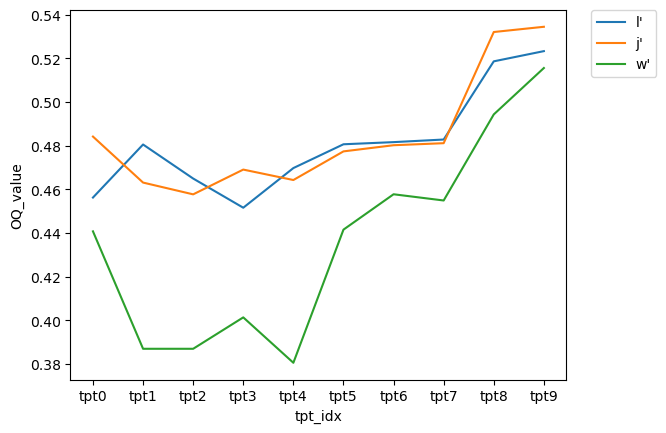

In [223]:
# plot glottalized sonorants
p1 = sns.lineplot(x='tpt_idx',y='OQ_value',hue='phone_short', 
                  hue_order = ["l'", "j'","w'"], data=mean_df)
p1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
p1

<Axes: xlabel='tpt_idx', ylabel='OQ_value'>

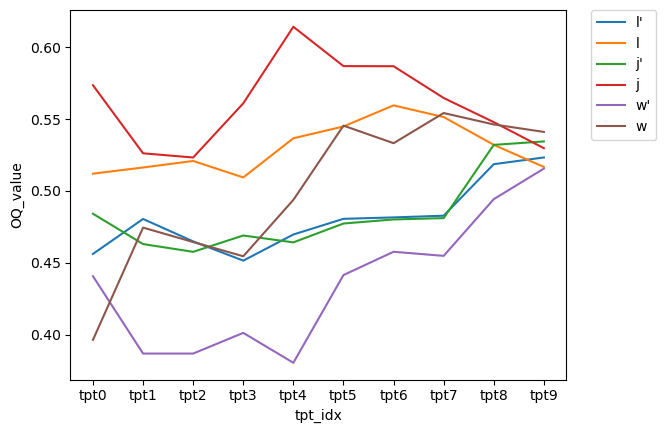

In [251]:
# plot all sonorants
p2 = sns.lineplot(x='tpt_idx',y='OQ_value', hue='phone_short', 
                   hue_order = ["l'", 'l', "j'", 'j', "w'", 'w'],
                   data=mean_df, errorbar=None)
#p1b.set_ylim(0.52, 0.57)
p2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
p2

In [229]:
sons = ['l', 'j', 'w', "l'", "j'", "w'"]
sons_df = mean_df[mean_df['phone_short'].isin(sons)]
sons_df['phone_short'].unique()

array(['j', "j'", 'l', "l'", 'w', "w'"], dtype=object)

<Axes: xlabel='tpt_idx', ylabel='OQ_value'>

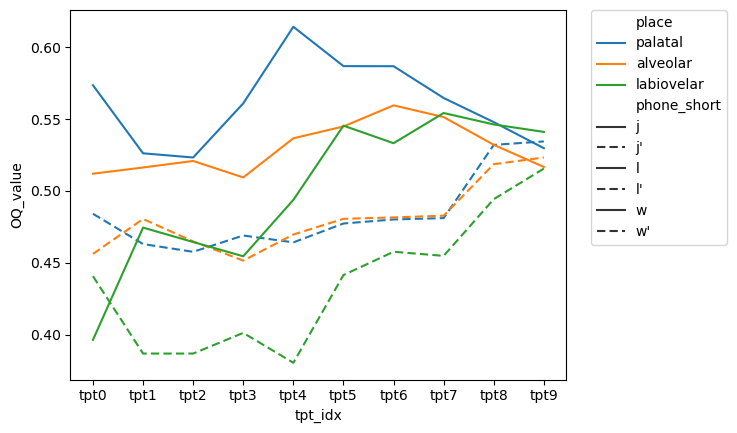

In [252]:
# plot sonorants, separated by place and type
line_styles = {
    'j': '',
    "j'": (4, 2), 
    'l': '',
    "l'": (4, 2), 
    'w': '',
    "w'": (4, 2) 
}

# Create the line plot
p3 = sns.lineplot(
    x='tpt_idx', y='OQ_value',
    hue='place', style='phone_short',
    markers=False, dashes=line_styles,
    data=sons_df, errorbar=None
)

# Set plot limits (optional)
# p3.set_ylim(0.52, 0.57)

# Adjust legend position
p3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Display the plot
p3

### Labiovelars only

In [235]:
tptdf_labvel = tptdf[(tptdf['phone_short'] == 'ɡb') | (tptdf['phone_short'] == "kp")] 
tptdf_labvel = tptdf_labvel.groupby(['tpt_idx','phone_short'])['OQ_value'].mean()
tptdf_labvel = pd.DataFrame(tptdf_labvel)

<Axes: xlabel='tpt_idx', ylabel='OQ_value'>

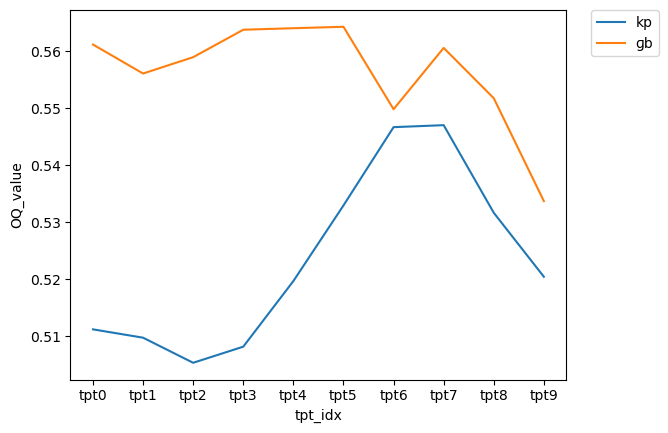

In [253]:
p4 = sns.lineplot(x='tpt_idx',y='OQ_value',hue='phone_short',data=tptdf_labvel)
p4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
p4

### [b] vs. [ɓ]

In [238]:
tptdf_b = tptdf[(tptdf['phone_short'] == 'ɓ') | (tptdf['phone_short'] == "b")] 
#tptdf_b = tptdf_b.groupby(['tpt_idx','phone'])['OQ_value'].mean()
tptdf_b

,index,tpt,tpt_idx,t1,t2,phone,word,recording,OQ_value,OQ_time,phone_short,type,place,word_type
0,0,2.963788,tpt0,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.528571,2.965,ɓ,implosive,bilabial,khuɓ
1,1,2.971204,tpt1,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.586667,2.970,ɓ,implosive,bilabial,khuɓ
2,2,2.978620,tpt2,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.616352,2.980,ɓ,implosive,bilabial,khuɓ
3,3,2.986036,tpt3,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.618497,2.990,ɓ,implosive,bilabial,khuɓ
4,4,2.993452,tpt4,2.963788,3.030533,ɓ,khuɓ,lob_san_20230323_acg_EGG_SIGNAL_1.wav,0.618497,2.990,ɓ,implosive,bilabial,khuɓ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6465,5,1617.184040,tpt5,1617.163650,1617.200353,ɓ,kʰʊɓa_2,SH_20230829_115041_EGG6.wav,0.647887,1617.185,ɓ,implosive,bilabial,khʊɓa
6466,6,1617.188119,tpt6,1617.163650,1617.200353,ɓ,kʰʊɓa_2,SH_20230829_115041_EGG6.wav,0.647887,1617.190,ɓ,implosive,bilabial,khʊɓa
6467,7,1617.192197,tpt7,1617.163650,1617.200353,ɓ,kʰʊɓa_2,SH_20230829_115041_EGG6.wav,0.647887,1617.190,ɓ,implosive,bilabial,khʊɓa
6468,8,1617.196275,tpt8,1617.163650,1617.200353,ɓ,kʰʊɓa_2,SH_20230829_115041_EGG6.wav,0.644928,1617.195,ɓ,implosive,bilabial,khʊɓa


<Axes: xlabel='tpt_idx', ylabel='OQ_value'>

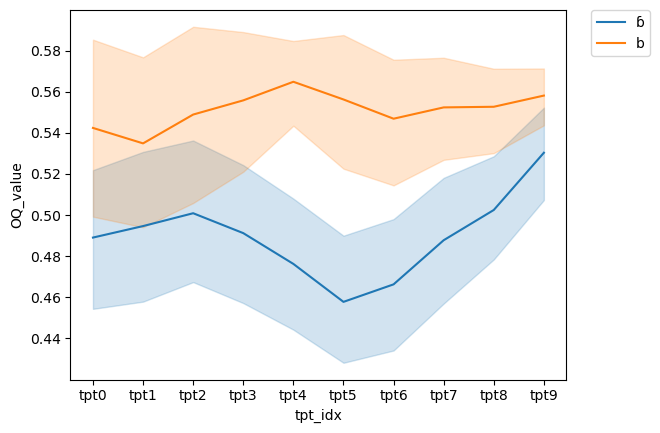

In [254]:
p5 = sns.lineplot(x='tpt_idx',y='OQ_value',hue='phone_short',data=tptdf_b)
p5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
p5

In [68]:
tptdf_son = tptdf_ALL[(tptdf_ALL['phone'] == 'l') | (tptdf_ALL['phone'] == "j") | (tptdf_ALL['phone'] == "w") | 
                     (tptdf_ALL['phone'] == "l'") | (tptdf_ALL['phone'] == "j'") | (tptdf_ALL['phone'] == "w'")] 
tptdf_son = tptdf_son.groupby(['tpt_idx','phone'])['OQ_value'].mean()
tptdf_son = pd.DataFrame(tptdf_son)

<AxesSubplot: xlabel='tpt_idx', ylabel='OQ_value'>

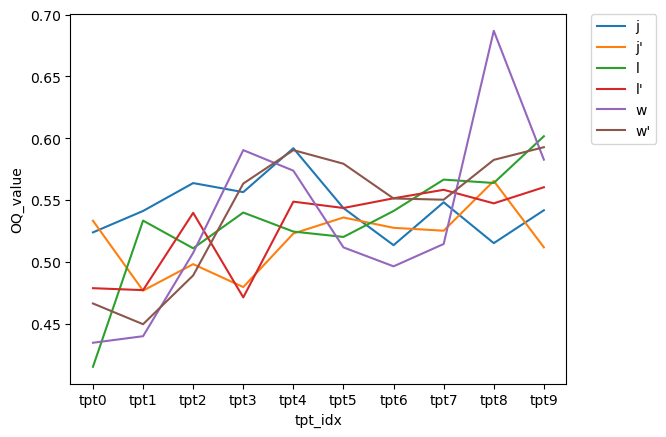

In [69]:
p5 = sns.lineplot(x='tpt_idx',y='OQ_value',hue='phone',data=tptdf_son)
p5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
p5

In [235]:
tptdf_son1 = tptdf[(tptdf['phone'] == 'l') | (tptdf['phone'] == "j") | (tptdf['phone'] == "w") | 
                     (tptdf['phone'] == "l'") | (tptdf['phone'] == "j'") | (tptdf['phone'] == "w'")] 

<Axes: xlabel='tpt_idx', ylabel='OQ_value'>

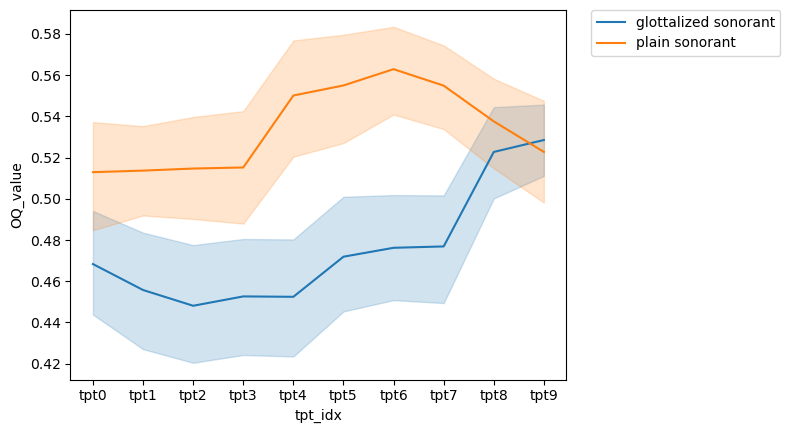

In [236]:
p1b = sns.lineplot(x='tpt_idx',y='OQ_value',hue='type', data=tptdf_son1)
p1b.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
p1b

### All labials

In [255]:
tptdf_lab = tptdf[(tptdf['phone_short'] == 'b') | (tptdf['phone_short'] == 'ɓ') | (tptdf['phone_short'] == 'kp') | 
                     (tptdf['phone_short'] == 'ɡb') | (tptdf['phone_short'] == 'kʷ')] 
tptdf_lab = tptdf_lab.groupby(['tpt_idx','phone_short'])['OQ_value'].mean()
tptdf_lab = pd.DataFrame(tptdf_lab)
tptdf_lab.head()

OQ_value
tpt_idx phone_short          
tpt0    b            0.542392
        kp           0.511240
        ɓ            0.489070
        ɡb           0.561130
tpt1    b            0.534876

<Axes: xlabel='tpt_idx', ylabel='OQ_value'>

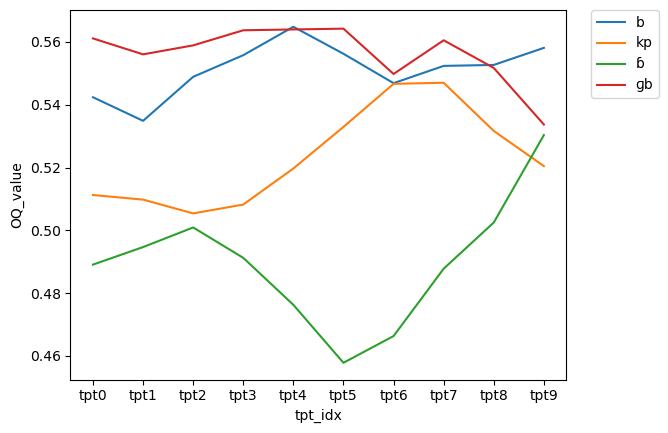

In [256]:
p6 = sns.lineplot(x='tpt_idx',y='OQ_value',hue='phone_short',data=tptdf_lab)
p6.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
p6

In [70]:
p3a = sns.lineplot(x='tpt_idx',y='OQ_value',hue='phone',data=res_lv)
p3a.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
p3a

NameError: name 'res_lv' is not defined

In [29]:
res_lab = long_res_type[(tptdf['phone'] == 'gb') | (tptdf['phone'] == "kp") | (tptdf['phone'] == "b") | (tptdf['phone'] == "ɓ")]
res_lab

,index,tpt,tpt_idx,t1,t2,phone,word,type,OQ_value,OQ_time
0,0,70.250136,tpt0,70.250136,70.852006,b,banbri,plain_stop,0.578431,70.250
1,1,70.317010,tpt1,70.250136,70.852006,b,banbri,plain_stop,0.330097,70.310
2,2,70.383885,tpt2,70.250136,70.852006,b,banbri,plain_stop,0.639752,70.385
3,3,70.450759,tpt3,70.250136,70.852006,b,banbri,plain_stop,0.558442,70.450
4,4,70.517634,tpt4,70.250136,70.852006,b,banbri,plain_stop,0.527273,70.520
...,...,...,...,...,...,...,...,...,...,...
2645,5,581.728250,tpt5,581.415738,581.978259,w',w'ii-rá,glott_son,0.541667,581.730
2646,6,581.790752,tpt6,581.415738,581.978259,w',w'ii-rá,glott_son,0.570248,581.790
2647,7,581.853255,tpt7,581.415738,581.978259,w',w'ii-rá,glott_son,0.550847,581.855
2648,8,581.915757,tpt8,581.415738,581.978259,w',w'ii-rá,glott_son,0.611650,581.915


<AxesSubplot: xlabel='tpt_idx', ylabel='OQ_value'>

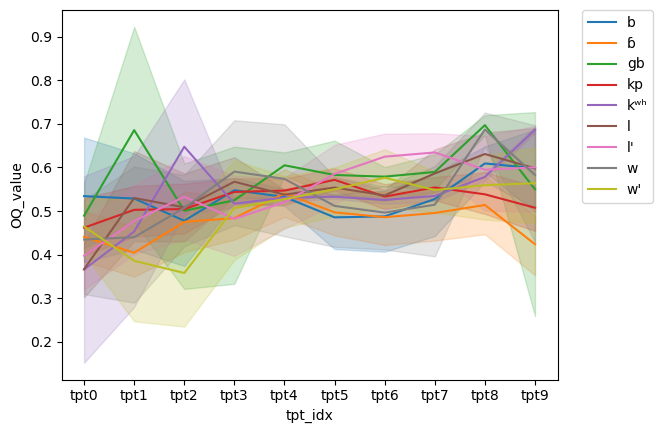

In [30]:
p3b = sns.lineplot(x='tpt_idx',y='OQ_value',hue='phone',data=res_lab)
p3b.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
p3b

In [24]:
res_b = long_res_type[(long_res_type['phone'] == 'b') | (long_res_type['phone'] == 'ɓ')]
res_b

NameError: name 'long_res_type' is not defined

### ɓ + glott son

In [247]:
impl_gl = ['ɓ', "l'", "j'", "w'"]
implglotson = mean_df[mean_df['phone_short'].isin(impl_gl)]
implglotson.head()

,phone_short,tpt_idx,type,place,OQ_value
20,j',tpt0,glottalized sonorant,palatal,0.484145
21,j',tpt1,glottalized sonorant,palatal,0.463065
22,j',tpt2,glottalized sonorant,palatal,0.457669
23,j',tpt3,glottalized sonorant,palatal,0.469019
24,j',tpt4,glottalized sonorant,palatal,0.464236


<Axes: xlabel='tpt_idx', ylabel='OQ_value'>

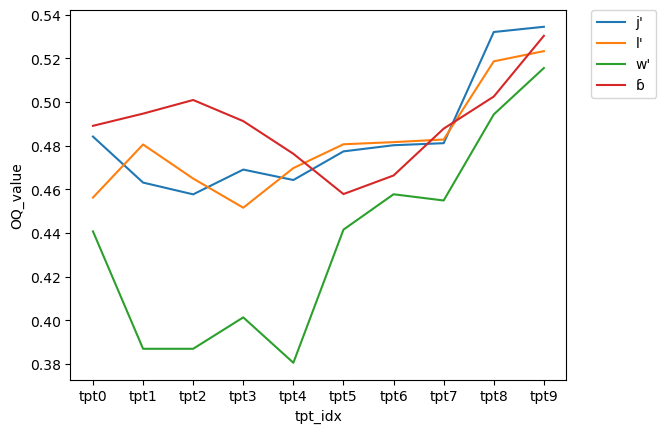

In [248]:
p7 = sns.lineplot(x='tpt_idx',y='OQ_value',hue='phone_short',data=implglotson)
p7.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
p7

### b + glott son

In [249]:
b_gl = ['b', "l'", "j'", "w'"]
bglotson = mean_df[mean_df['phone_short'].isin(b_gl)]
bglotson.head()

,phone_short,tpt_idx,type,place,OQ_value
0,b,tpt0,plain stop,bilabial,0.542392
1,b,tpt1,plain stop,bilabial,0.534876
2,b,tpt2,plain stop,bilabial,0.548898
3,b,tpt3,plain stop,bilabial,0.555794
4,b,tpt4,plain stop,bilabial,0.564838


<Axes: xlabel='tpt_idx', ylabel='OQ_value'>

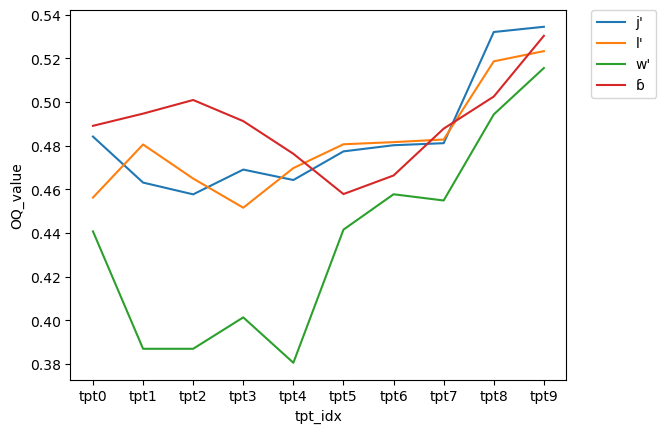

In [257]:
p8 = sns.lineplot(x='tpt_idx',y='OQ_value',hue='phone_short',data=implglotson)
p8.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
p8